# Tutorial: Understanding MetaDynamics: Introduction

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_metad_intro.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will learn the basics of Metadynamics method for accelerting the sampling in MD simulations.

Prerquisites:
- It is expected that you have accomplished plumed_intro.ipynb and plumed_bias.ipynb tutorials.
- It is suggested that one reads following:
    - https://www.youtube.com/watch?v=PxJP16qNCYs&t=1s
    - https://en.wikipedia.org/wiki/Metadynamics
    - [Metadynamics, Review, CMS, 2011](https://onlinelibrary.wiley.com/doi/pdf/10.1002/wcms.31) - this review is recommended for advanced understanding of MetaD.
    


Useful theoretical papers to read: 
- [Jarzynski equality](https://arxiv.org/pdf/cond-mat/9610209.pdf)
- [Equilibrium Free Energies from Nonequilibrium Metadynamics, PRL, 2006](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.090601)
- [Assessing the Accuracy of Metadynamics, PhysChemB, 2005](https://pubs.acs.org/doi/abs/10.1021/jp045424k?src=recsys&journalCode=jpcbfk)
- https://arxiv.org/pdf/1106.4994.pdf

Some useful tutorials:
- See PLUMED tutorials https://plumed.github.io/doc-v2.5/user-doc/html/tutorials.html
- Especially, this one https://plumed.github.io/doc-v2.5/user-doc/html/trieste-4.html

Other:
- Full PLUMED documentation is here https://plumed.github.io/doc-v2.5/user-doc/html/_syntax.html
- For full Gromacs manual, see here http://manual.gromacs.org



## Step 1. Prepare alanine in a water box for simulations.
These steps repeat the ideas of plumed_intro.ipynb tutorial, but make a smaller system - dipeptide in a water box.


In [1]:
%%bash --out output --err error
wget https://files.rcsb.org/view/1KX5.pdb

In [24]:
import MDAnalysis as mda
nucl=mda.Universe("1KX5.pdb")

sel_text="(segid B and (resid 33 or (resid 32 and name C O CA) or (resid 34 and name N CA)))"
h4helix=nucl.select_atoms(sel_text)


nucl.select_atoms("segid B and resid 32").residues.resnames='ACE'
nucl.select_atoms("segid B and resid 32 and name CA").atoms.names='CH3'
nucl.select_atoms("segid B and resid 34").residues.resnames='NME'
nucl.select_atoms("segid B and resid 34 and name CA").atoms.names='CH3'


nucl.trajectory.remarks=[]
nucl.trajectory.compound=[]
nucl.trajectory.header=['H4 helix']

#print(dimer.atoms.names)
h4helix.write("sys.pdb")

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [20]:
#First get mdp files.
!rm -rf MDProtocols
from funcs import get_files_from_git
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber_quick"
get_files_from_git(prot_url,'MDProtocols/')

In [26]:
!gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff amber99sb-ildn >/dev/null 2>&1
#Comment out >/dev/null 2>&1 if you see errors or to see output of the command
#Same in all commands below, the output is supressed to save space

In [27]:
#First put a system in a periodic box, with 1 nm distance to the walls (-d), centered in the box (-c)
!gmx editconf -d 1 -c -f init.pdb -o init_box.pdb >/dev/null 2>&1

In [28]:
#Now to the solvation, note, the topology file will be updated to reflect the added water molecules.
!gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top >/dev/null 2>&1

In [29]:
!gmx grompp -f MDProtocols/ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1 >/dev/null 2>&1

In [30]:
%%bash
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -conc 0.150 -neutral <<! >/dev/null 2>&1
SOL
!

The `grompp` comand packs topology together with mdp file into a .tpr file - the sole file needed to start minimization/simulation.
See details here http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html

In [31]:
!gmx grompp -f MDProtocols/minim.mdp -c init_solv_ions.pdb -p topol.top -o minim.tpr -r init_solv_ions.pdb >/dev/null 2>&1

Now let's run the minimization, this may take a while ...

In [32]:
!gmx mdrun -nt 10 -deffnm minim >/dev/null 2>&1 # nt is the number of threads, choose less than the number of CPUs you have

In [33]:
!gmx grompp -f MDProtocols/equil.mdp -c minim.gro -p topol.top -o equil.tpr -r init_solv_ions.pdb >/dev/null 2>&1

In [34]:
!gmx mdrun -nt 10 -deffnm equil >/dev/null 2>&1  # nt is the number of threads, choose less than the number of CPUs you have

Finally, let's prepare the 0.1 ns production files for equilibrium run, and for MetaD to compare later. And also prepare longer simulation files of 1 ns and 10 ns.

In [34]:
!gmx grompp -f MDProtocols/prod.mdp -c equil.gro -p topol.top -o prod_eq.tpr -r init_solv_ions.pdb >/dev/null 2>&1
!gmx grompp -f MDProtocols/prod.mdp -c equil.gro -p topol.top -o prod.tpr -r init_solv_ions.pdb >/dev/null 2>&1
!cp MDProtocols/prod.mdp MDProtocols/prod1ns.mdp
!cp MDProtocols/prod.mdp MDProtocols/prod2ns.mdp
!cp MDProtocols/prod.mdp MDProtocols/prod10ns.mdp
!cp MDProtocols/prod.mdp MDProtocols/prod100ns.mdp
!sed -i 's/50000/500000/g' MDProtocols/prod1ns.mdp
!gmx grompp -f MDProtocols/prod1ns.mdp -c equil.gro -p topol.top -o prod1ns.tpr -r init_solv_ions.pdb >/dev/null 2>&1
!sed -i 's/50000/1000000/g' MDProtocols/prod2ns.mdp
!gmx grompp -f MDProtocols/prod2ns.mdp -c equil.gro -p topol.top -o prod2ns.tpr -r init_solv_ions.pdb >/dev/null 2>&1
!sed -i 's/50000/5000000/g' MDProtocols/prod10ns.mdp
!gmx grompp -f MDProtocols/prod10ns.mdp -c equil.gro -p topol.top -o prod10ns.tpr -r init_solv_ions.pdb >/dev/null 2>&1
!sed -i 's/50000/50000000/g' MDProtocols/prod100ns.mdp
!gmx grompp -f MDProtocols/prod100ns.mdp -c equil.gro -p topol.top -o prod100ns.tpr -r init_solv_ions.pdb >/dev/null 2>&1


## Step 2. First let's do an anbiased run and explore some dihedral angles in our dipeptide.


MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb
t1: TORSION ATOMS=@phi-33
t2: TORSION ATOMS=@psi-33
PRINT ARG=t1,t2 FILE=colvar_eq.dat STRIDE=10
Labels found: ['time', 't1', 't2']


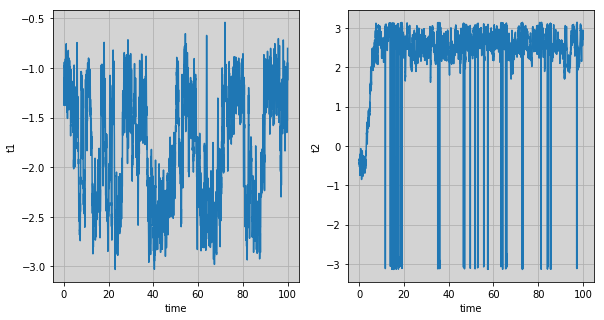

Text(0.5, 1.0, 'Ramachandran plot')

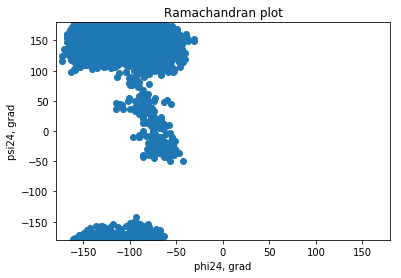

In [36]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed.dat
!echo "psi33: TORSION ATOMS=@psi-33" >>plumed.dat
!echo "PRINT ARG=phi33,psi33 FILE=colvar_eq.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod_eq -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar_eq.dat',figsize=(5,5))
import matplotlib
import matplotlib.pyplot as plt
plt.plot(data[:,1]*180./3.14159,data[:,2]*180./3.14159,'o')
plt.xlabel('phi33, grad')
plt.ylabel('psi33, grad')
plt.xlim(-180,180)
plt.ylim(-180,180)
plt.title('Ramachandran plot')

In [37]:
#here is the file that we get 
!head colvar.dat

#! FIELDS time t1 t2 meta.bias
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET min_t2 -pi
#! SET max_t2 pi
 0.000000 -2.019485 -1.288952 0.000000
 0.020000 -2.235047 -1.177582 0.000000
 0.040000 -2.172600 -1.109725 0.000000
 0.060000 -2.159979 -1.254691 0.000000
 0.080000 -2.484705 -1.186914 0.000000


In [61]:
%%bash  --err err --out out
#Let's do a visualization by aligning the peptide first.
gmx make_ndx -f init_box.pdb -o index_ref.ndx <<!
r 33 & "Backbone"
q
!
gmx trjconv -f prod_eq.xtc -s prod_eq.tpr -o prod_eq_1.xtc -pbc whole << !
Protein
!
gmx trjconv -f prod_eq_1.xtc -s prod_eq.tpr -o prod_eq_2.xtc -pbc cluster << !
Protein
Protein
!
gmx trjconv -n index_ref.ndx -f prod_eq_2.xtc -s init_box.pdb -o sys_md.xtc -fit rot+trans << !
r_33_&_Backbone
System
!


In [62]:
import nglview as nv
import MDAnalysis as mda
MD=mda.Universe('init_box.pdb','sys_md.xtc')
#MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
u=nv.show_mdanalysis(MD)
u.clear()
u.add_representation(selection="all",repr_type='licorice')
u

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=11)

## Step 3. Now let's start to explore MetaDynamics


### Some theory first.
MetaD is one of the adaptive methods to estimate free energies (others are e.g. Wang-Landau method).

In MetaD we are adding the following time dependent potential to the system
$$V_{bias}(\vec{s},t) = \sum_{ k \tau < t} W(k \tau) \exp\left( -\sum_{i=1}^{d} \frac{(s_i-s_i^{(0)}(k \tau))^2}{2\sigma_i^2} \right).$$
along a number of CVs with the aim of making the system to explore different regions of phase space and estimate the free energy surface (FES) in the CVs space.

Note an important aspect $d$ - is the number of CVs that you are simultaneously biasing. And the Gassians are $d$-dimensional, i.e. $e^{s_1^2+s_2^2+s_3^2+...}$ and not $e^{s_1^2}+e^{s_2^2}+e^{s_3^2}+...$. This means that we are pushing the system out from vising certain states (points) in $d$-dimensional space, when we simultaneously do MetaD with several variables. The multidimensional Gaussian kenels is also the reason that it is difficult to do MetaD in with more than 2-3 CVs - the number of Gussian kernels needed to cover this space grows exponentially with $d$.

Eventually during the MetaD simulations:
- the MetaD biasing potential should fill the FES basins (like "sand") and the motion of the system along the CV should become diffusive.
- The MetaD potential is expected to approximate the FES taken with a minus sign $-F(\vec{s})$
- In fact the MetaD potential will oscillate around $-F(\vec{s})$ with an error of $\epsilon^2 \propto \frac{W/\tau}{D}$ (see below and this [ref](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.090601)).
- In theory the MetaD potential should be averaged out over the region where the dynamics has become diffusive to get the FES 
$$\bar F(\vec s) = - \frac{1}{t_\text{sim} - t_\text{diff}}
                          \int^{t_\text{sim}}_{t_\text{diff}} \!\!\!\!\!V_\text{bias}(\vec s, t)\, dt + C$$

The non-Markovian nature of MetaD approach gives some difficulties in theoretical description of the underlying thermodynamics.
- It is usually assumed that "that  in real  systems  the quantitative behavior  of  metadynamics is  perfectly  reproduced  by  the  Langevin  equation  in  its strong  friction  limit.  This  is  due  to  the  fact  that  in  real systems all the relaxation times are usually much smaller than the typical diffusion time in the CVs’ space, and are therefore averaged out during a metadynamics reconstruction. Hence,"... the CVs’ evolution can be modeled as a Langevin-type  dynamics. [ref](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.090601) 
- It is unclear (at least to he authors of the tutorial) if there are any theoretical limits on the rate of perturbation (energy rate $W/\tau$).
- However, in more popular setups, discussed later such as Well-Tempered MetaD, the rate of perturbation is gradually reduced over simulation time so the perturbations should diminish and the MetaD potential converge to the FES.
- It is also clear, that if the rate of perturbation is two high, the system may not be able to adapt to the conformational change along the degrees of freedom ortogonal to the CV.


### MetaD parameters
In the original implementation of metadynamics there are three main parameters:
- sigma
    - Small sigma - good spatial resoultion, but slow sampling.
    - Large sigma - faster sampling, but low resolution, you may miss the details of the free energy surface (FESs, e.g. important minima where system resides.
    - Thus ideally sigma should correspond to the ruggedness of the free energy surface - be small enough to sample all the relevant basins of FES.
    - The ruggedness at the starting point can be estimated from CV fluctuations in an equlibrium run. The fluctuations should correspond to width of the energy well at around kT. You can then choose sigma less than these fluctuations. However, this does not garantee that other energy minima along the CV will have the same width.
- tau - hills (Gaussians) deposition rate
- W - Gaussian height
    - W/tau is the energy rate of the bias and this is what really matters.
- How to choose W/tau?
    - First it should be small enough that the simulation is stable, not exploding, the temperature and energy are within the limits of an equilibrium run, otherwise at least we will sample FES at a different temperature than we want, and clearly the perturbation will be highly non-equilibrium.
    - It is also clear, that if the rate of perturbation is two high, the system may not be able to adapt to the conformational change along the degrees of freedom ortogonal to the CV. This will hinder convergence.
    - Usual suggestions are to keep W < kT, tau is usually around 1 ps.
    - We will experiment with different parameters and see how they affect convergence later.
    - As shown [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.090601) in classical MetaD the resulting MetaD potential will fluctuate around the minus free energy value with an error of $\epsilon^2 \propto \frac{W/\tau}{D}$ , where D - is diffusion coefficient



### Running MetaD: understanding input parameters and output
Let's do a classical run with sigma of 0.2 radians (around 10 degrees) on the psi, phi angle of a residue in our alpha-helix.
User is suggested to try different parameters below.
- Experiment with different values of SIGMA and HEIGHT
    - At SIGMA=0.02 and HEIGHT=10, PACE=50 - the system is exploding - Segmentation fault.
    - At SIGMA=0.02 and HEIGHT=8,  PACE=50 - the system is heating up.
    - At SIGMA=0.2 and HEIGHT=10,  PACE=50 - we get the full coverage of phase space.
- See if the temperature and energy of the system will be able to stay within equilibrium limits, and see Ramachandran plot MetaD versus equlibrium.




MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb
phi33: TORSION ATOMS=@phi-33
psi33: TORSION ATOMS=@psi-33
meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat
PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10
250.54user 1.85system 0:26.03elapsed 969%CPU (0avgtext+0avgdata 33780maxresident)k
0inputs+1544outputs (0major+12623minor)pagefaults 0swaps
Labels found: ['time', 'phi33', 'psi33', 'meta.bias', 'meta.work']


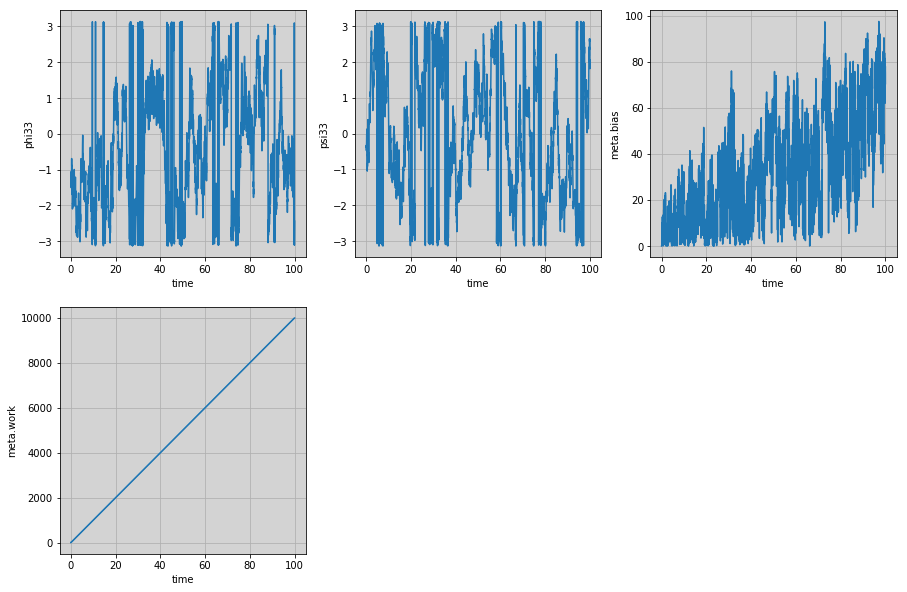

Labels found: ['time', 't1', 't2']


Text(0.5, 1.0, 'Ramachandran plot')

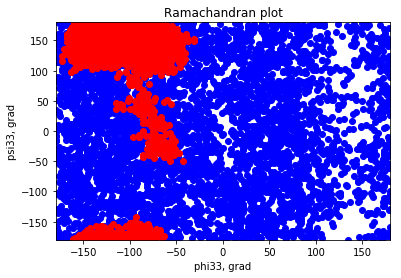

In [13]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed.dat
!echo "psi33: TORSION ATOMS=@psi-33" >>plumed.dat
!echo "meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat" >>plumed.dat
#meta.bias - will be the instantenous value of the bias potential
#meta.work - accmulated work
!echo "PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
#We'll also do timing of MD run with time
!time -o timing.txt gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
!cat timing.txt
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))
import matplotlib
import matplotlib.pyplot as plt
#We will make a Ramachandran plot versus the same plot for the equilibrium (non-MetaD case)
data_eq=plot_plumed('colvar_eq.dat',plot=False)
plt.plot(data[:,1]*180./3.14159,data[:,2]*180./3.14159,'bo')
plt.plot(data_eq[:,1]*180./3.14159,data_eq[:,2]*180./3.14159,'ro')
plt.xlabel('phi33, grad')
plt.ylabel('psi33, grad')
plt.xlim(-180,180)
plt.ylim(-180,180)
plt.title('Ramachandran plot')

We see following things:
- On the Ramachandran plot the sample converage has increased considerably.
- The accumulated work grows linearly, because every Gaussian added is equivalent to an instanteneous work on the system which equals its HEIGHT.

Last Frame read : 51, time : 100.0 ps
51 frame read in 0.03 seconds
Last Frame read : 51, time : 100.0 ps
51 frame read in 0.02 seconds


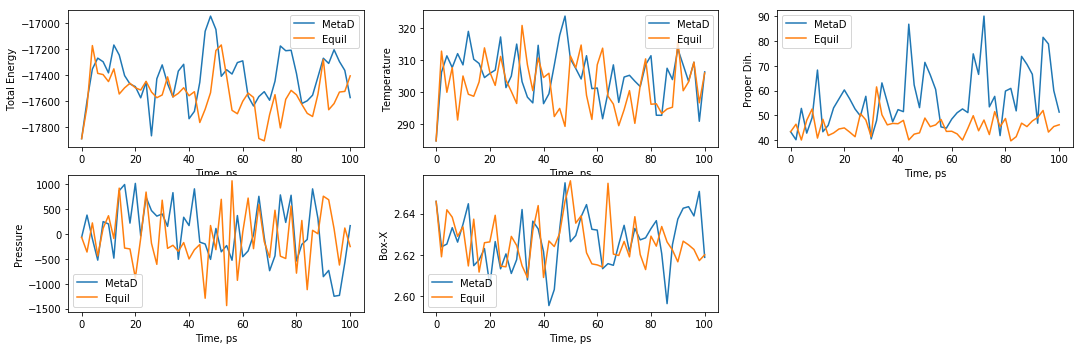

In [78]:
#Let's explore the parameters of the run
import panedr
df_eq = panedr.edr_to_df('prod_eq.edr', verbose=True)
df = panedr.edr_to_df('prod.edr', verbose=True)

num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(['Total Energy','Temperature','Proper Dih.','Pressure','Box-X'],1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key],label='MetaD')
    ax.plot(df_eq[key],label='Equil')
    ax.set_xlabel('Time, ps')
    ax.set_ylabel(key)
    ax.legend()    
plt.show()

#! FIELDS time t1 t2 sigma_t1 sigma_t2 height biasf
#! SET multivariate false
#! SET kerneltype gaussian
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET min_t2 -pi
#! SET max_t2 pi
     0.1000000047497451     -1.133249286217688    -0.4693819994462962                    0.2                    0.2                     10                     -1
     0.2000000094994903     -1.508115298734554   -0.09561197594802229                    0.2                    0.2                     10                     -1
     0.3000000142492354     -1.055903541387046    -0.1140479950406106                    0.2                    0.2                     10                     -1
Labels found: ['time', 't1', 't2', 'sigma_t1', 'sigma_t2', 'height', 'biasf']


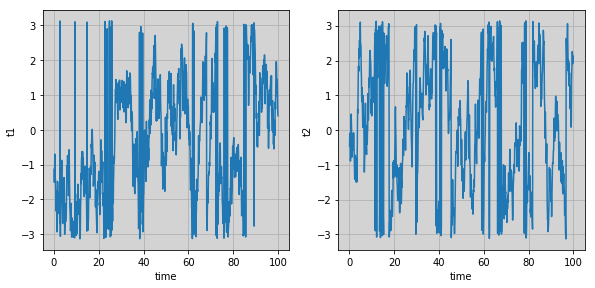

In [116]:
#HILLS.dat is the file that contains information about the deposited Gaussians
#All columns are self-explanatory
#The last one is the BAISFACTOR and plays role only in well tempered metadynamics
!head HILLS.dat
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('HILLS.dat',figsize=(5,5),col2plot=[1,2])

Labels found: ['time', 't1', 't2', 'sigma_t1', 'sigma_t2', 'height', 'biasf']


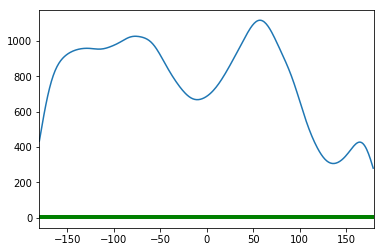

In [117]:
#Let's plot the Gaussians and their sum
#The green thick line at the bottom of the resulting plot - are the Gaussians.
import matplotlib
import matplotlib.pyplot as plt
from funcs import plot_plumed
import numpy as np
%matplotlib inline
data=plot_plumed('HILLS.dat',figsize=(5,5),plot=False)

t1=data[:,1]
sigma1=data[:,3]
W1=data[:,5]

def meta_pot(x):
    rad=x/180.*3.14159
    return np.sum(W1*np.exp(-(rad-t1)**2/(2*sigma1*sigma1)))
x=np.arange(-180.,180.)
y=np.array(list(map(meta_pot,x)))
plt.plot(x,y)
plt.xlim(-180,180)
#plt.ylim(0,10)
for i in range(len(t1)):
    rad=x/180.*3.14159
    y=W1[i]*np.exp(-(rad-t1[i])**2/(2*sigma1[i]*sigma1[i]))
    plt.plot(x,y,'g-')

In [118]:
%%bash  --err err --out out
#Let's do a visualization by aligning the peptide first.
gmx trjconv -f prod.xtc -s prod.tpr -o prod_1.xtc -pbc whole << !
Protein
!
gmx trjconv -f prod_1.xtc -s prod.tpr -o prod_2.xtc -pbc cluster << !
Protein
Protein
!
gmx trjconv -n index_ref.ndx -f prod_2.xtc -s init_box.pdb -o sys_md.xtc -fit rot+trans << !
r_33_&_Backbone
System
!


In [119]:
import nglview as nv
import MDAnalysis as mda
MD=mda.Universe('init_box.pdb','sys_md.xtc')
#MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
u=nv.show_mdanalysis(MD)
u.clear()
u.add_representation(selection="all",repr_type='licorice')
u

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=11)

In [121]:
#We will use sum_hills tool to get FreeEnergy
!plumed sum_hills --hills HILLS.dat --outfile sumhills.dat >/dev/null
!head -n 12 sumhills.dat

#! FIELDS t1 t2 file.free der_t1 der_t2
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET nbins_t1  89
#! SET periodic_t1 true
#! SET min_t2 -pi
#! SET max_t2 pi
#! SET nbins_t2  89
#! SET periodic_t2 true
   -3.141592654   -3.141592654  -65.170881213  -70.825474654   47.062344451
   -3.070995066   -3.141592654  -70.010039552  -66.413977076   54.431037497
   -3.000397478   -3.141592654  -74.542888336  -62.032066727   65.391127767


Labels found: ['t1', 't2', 'file.free', 'der_t1', 'der_t2']


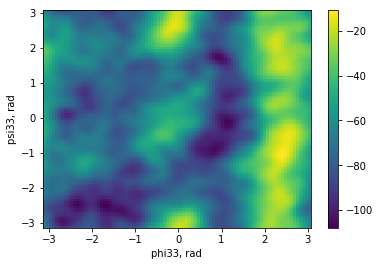

In [122]:
import matplotlib
import matplotlib.pyplot as plt
from funcs import plot_plumed
import numpy as np


%matplotlib inline
data=plot_plumed('sumhills.dat',figsize=(5,5),plot=False)
x_list = data[:,0]
y_list = data[:,1]
z_list = data[:,2]

N = int(len(z_list)**.5)
z = z_list.reshape(N, N)
plt.imshow(z, extent=(np.amin(x_list), np.amax(x_list), np.amin(y_list), np.amax(y_list)),  aspect = 'auto')
plt.colorbar()
plt.xlabel('phi33, rad')
plt.ylabel('psi33, rad')
plt.show()


#! FIELDS t1 projection
#! SET min_t1 -pi
#! SET max_t1 pi
#! SET nbins_t1  89
#! SET periodic_t1 true
   -3.141592654  -83.207987552
   -3.070995066  -86.775336196
   -3.000397478  -90.541356744
   -2.929799890  -94.776181403
   -2.859202303  -99.651194739
Labels found: ['t1', 'projection']


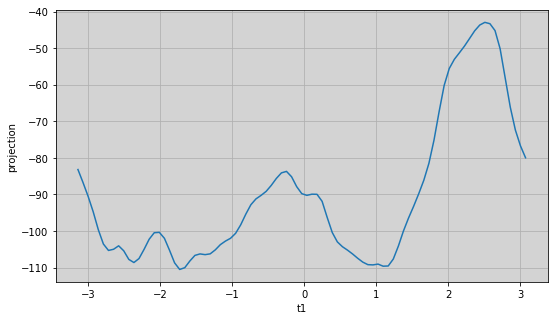

In [125]:
#Let's integrate out, and leave only one CV
#You'll need to specify the kt in kJ/mol here (2.4)
!plumed sum_hills --hills HILLS.dat --idw t1 --kt 2.4 --outfile sumhills.dat >/dev/null
!head sumhills.dat
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('sumhills.dat',figsize=(10,5),plot=True)

## Step 4. More tricks of the trade
- Using grid potential.
- Multiple walkers.
- Bias-exchange MetaD.

### Grid potentials.
In this example, the bias potential will be stored on a grid, whose boundaries are specified by the keywords GRID_MIN and GRID_MAX. Notice that you can provide either the number of bins for every collective variable (GRID_BIN) or the desired grid spacing (GRID_SPACING). In case you provide both PLUMED will use the most conservative choice (highest number of bins) for each dimension. In case you do not provide any information about bin size (neither GRID_BIN nor GRID_SPACING) and if Gaussian width is fixed, PLUMED will use 1/5 of the Gaussian width as grid spacing. This default choice should be reasonable for most applications.

In [18]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed.dat
!echo "psi33: TORSION ATOMS=@psi-33" >>plumed.dat
!echo "meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat GRID_MIN=-pi,-pi GRID_MAX=pi,pi" >>plumed.dat
#meta.bias - will be the instantenous value of the bias potential
#meta.work - accmulated work
!echo "PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!time -o timing.txt gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
!cat timing.txt

MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb
phi33: TORSION ATOMS=@phi-33
psi33: TORSION ATOMS=@psi-33
meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat GRID_MIN=-pi,-pi GRID_MAX=pi,pi
PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10
238.57user 1.85system 0:24.81elapsed 968%CPU (0avgtext+0avgdata 35200maxresident)k
0inputs+1544outputs (0major+15581minor)pagefaults 0swaps


Note, that the execution time is now less, than in the previous case

### Multiple walkers

Multiple Walker metadynamics is the simplest way to parallelize a metadynamics calculation: 
multiple simulation of the same system are run in parallel using metadynamics on the same set of collective variables.
The deposited bias is shared among the replicas in such a way that the history dependent potential depends on the whole history.
Multiple walkers are best run through the MPI version of Gromacs and Plumed.

See running multi-simulations in Gromacs manual http://manual.gromacs.org/documentation/2018.2/user-guide/mdrun-features.html

See also here https://plumed.github.io/doc-v2.5/user-doc/html/belfast-8.html

Let's do 4 walker through MPI.
First of all we need to prepare 4 tpr files with different random seeds for the thermostat ld-seed parameter.
Otherwise we'll get four identical simulations.

In [31]:
%%bash
for i in `seq 0 4`; do
cp MDProtocols/prod.mdp MDProtocols/prod_walkers$i.mdp
echo "ld-seed=$i" >> MDProtocols/prod_walkers$i.mdp
gmx grompp -f MDProtocols/prod_walkers$i.mdp -c equil.gro -p topol.top -o prod_walkers$i.tpr -r init_solv_ions.pdb -maxwarn 2 >/dev/null 2>&1
done

In [1]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "psi33: TORSION ATOMS=@psi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat GRID_MIN=-pi,-pi GRID_MAX=pi,pi WALKERS_MPI" >>plumed_walkers.dat
!echo "PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10" >>plumed_walkers.dat
!cat plumed_walkers.dat
#This was a least tested on linux with the given conda package.
#Might not work as expected on MacOS

!mpirun -np 4 mdrun_mpi -deffnm prod_walkers -plumed plumed_walkers.dat -multi 4 2> /dev/null 


MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb
phi33: TORSION ATOMS=@phi-33
psi33: TORSION ATOMS=@psi-33
meta: METAD ARG=phi33,psi33 SIGMA=0.2,0.2 HEIGHT=10 PACE=50 FILE=HILLS.dat GRID_MIN=-pi,-pi GRID_MAX=pi,pi WALKERS_MPI
PRINT ARG=phi33,psi33,meta.bias,meta.work FILE=colvar.dat STRIDE=10


In [2]:
#As a result we get 4 colvar files.
#colvar.0.dat
#colvar.1.dat
#colvar.2.dat
#colvar.3.dat
#And one HILLS.dat that is now four times as big!
#Let's check that they differ
!diff colvar.0.dat colvar.1.dat | head 

7,5006c7,5006
<  0.020000 -1.278431 -0.355665 0.000000 0.000000
<  0.040000 -1.267048 -0.328804 0.000000 0.000000
<  0.060000 -1.255429 -0.385067 0.000000 0.000000
<  0.080000 -1.302521 -0.343990 0.000000 0.000000
<  0.100000 -1.133307 -0.469389 0.000000 0.000000
<  0.120000 -1.453700 -0.117373 2.365602 39.999185
<  0.140000 -1.397757 -0.334993 13.353283 39.999185
<  0.160000 -1.644839 -0.148726 0.422523 39.999185
<  0.180000 -1.452191 -0.044539 1.180691 39.999185
diff: standard output: Broken pipe


Labels found: ['time', 'phi33', 'psi33', 'sigma_phi33', 'sigma_psi33', 'height', 'biasf']


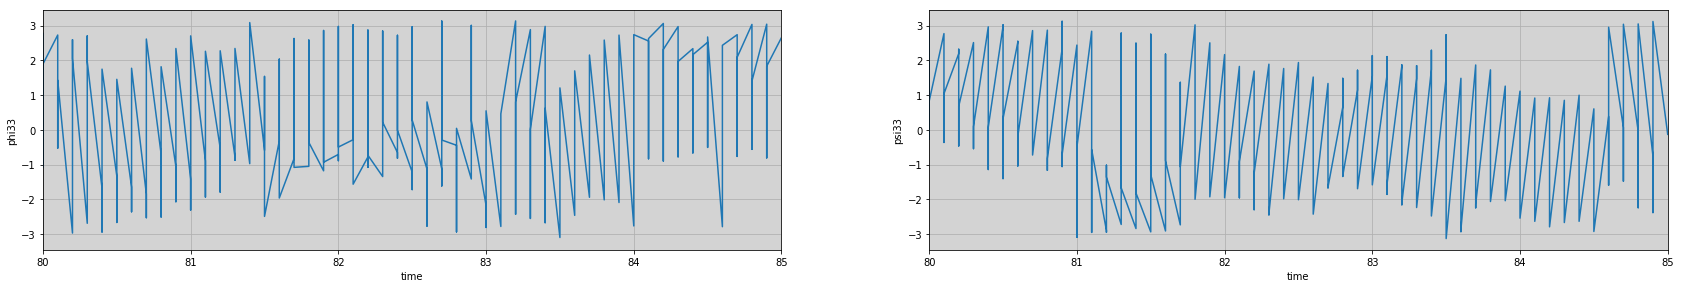

In [12]:
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('HILLS.dat',figsize=(15,5),col2plot=[1,2],xlim=[80,85])

### Bias-exchange MetaD.
In development

## Step 5: Calculating free energies and analyzing convergence: qualitative assessment
There are two necessary conditions for a good estimate (at least at the qualitative level):
- We should see convergence of profiles free energy with simulation time
- The system should diffuse freely along the CV.
- If it is not (showing hysteretic behavior - diffusion at some times, while get stuch in others), the CV might be not the best one, some hidden variables with slow dynamics might affect it.

Below we plot, convergence plots together with the CV diffusion.

Labels found: ['t1', 'projection']
Labels found: ['t1', 'projection']
Labels found: ['t1', 'projection']
Labels found: ['t1', 'projection']
Labels found: ['t1', 'projection']
Labels found: ['t1', 'projection']
Labels found: ['time', 't1', 't2', 'sigma_t1', 'sigma_t2', 'height', 'biasf']


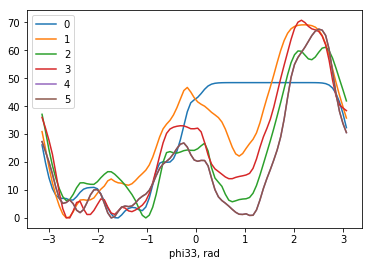

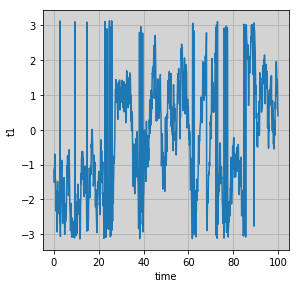

In [128]:
#Try to estimate convergence from blocks.
!plumed sum_hills --hills HILLS.dat --idw t1 --kt 2.4 --outfile sumhills.dat --stride 200 --mintozero >/dev/null
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
for i in range(6):
    data=plot_plumed('sumhills.dat%d.dat'%i,figsize=(5,5),plot=False)
    plt.plot(data[:,0],data[:,1],label="%d"%i)
plt.legend()
plt.xlabel('phi33, rad')
  
d=plot_plumed('HILLS.dat',figsize=(5,5),col2plot=[1])    

- We see that there is some sort of convergence in the profile, but currently to very quantitative.
- CV show a bit hysteretic behavior - meaning there are some hidden CVs (which is probabli psi angle).

For Selecting optimal paprameters for MetaD and quantitative analysis of convergence and MetaD errors, see next tutorial.

In [ ]:
#Some other usefull commmands
#Calculating histogram
#!plumed sum_hills --stride 100000 --nohistory --sigma 0.1 --kt 2.5   --histo HILLS_t1_02_1_200_100ns.dat  --outhisto big_data/histo_t1_02_1_200_100ns.dat  --mintozero  >/dev/null